cnt: The total number of bike rentals (casual + registered)

I will predict the cnt column using all of the other columns, except for casual and registered.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from os import listdir
from os.path import isfile, join
import csv
import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, SGDRegressor, PassiveAggressiveRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, mutual_info_regression, SelectFpr, SelectFdr, SelectFwe, RFE
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.utils import shuffle
from math import sqrt

In [2]:
import pandas
bike_rentals = pandas.read_csv("bike_rental_hour.csv", index_col=False)
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

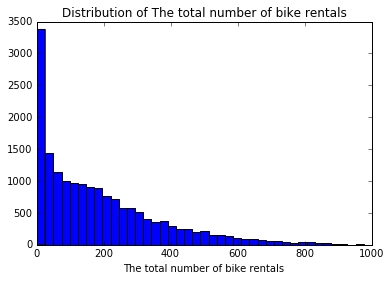

In [5]:
plt.hist(bike_rentals['cnt'], bins=40)
plt.title('Distribution of The total number of bike rentals')
plt.xlabel('The total number of bike rentals')
plt.show()

In [6]:
corrmat = bike_rentals.corr()
sorted_corrs = corrmat['cnt'].abs().sort_values(ascending=False)
sorted_corrs

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

In [7]:
def assign_label(hour):
    if hour >= 6 and hour < 12: 
        return 1
    elif hour >= 12 and hour < 18: 
        return 2
    elif hour >= 18 and hour < 24: 
        return 3    
    elif hour >= 0 and hour < 6: 
        return 4
 
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

In [8]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


In [9]:
bike_rentals = bike_rentals.drop(['instant', 'registered', 'casual'], axis=1)

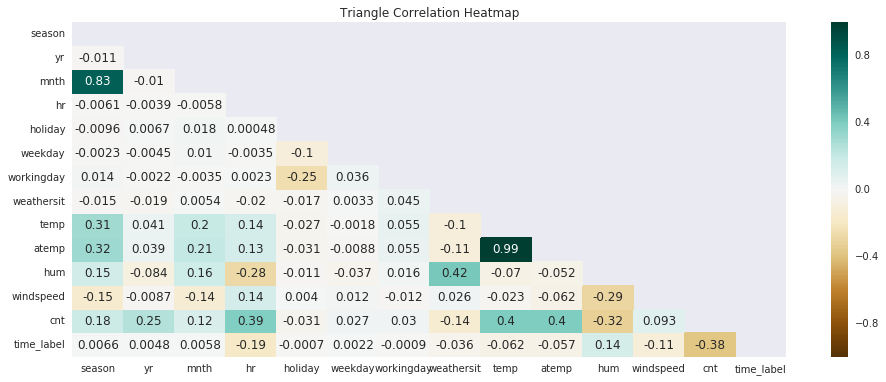

In [10]:
bike_rentals.corr()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(bike_rentals.corr(), dtype=np.bool))
heatmap = sns.heatmap(bike_rentals.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap')

    temp - The temperature, on a 0-1 scale
    atemp - The adjusted temperature
    hum - The humidity, on a 0-1 scale
    hr - The hour the rentals occurred

Since 'temp' and 'atemp' have 0.99 correlation we remove one of them due to multicollinearity!

Also 'season' and 'mnth' have corr_coefficient of 0.83. 


In [11]:
bike_rentals = bike_rentals.drop(['temp', 'mnth'], axis=1)

## Data Partitioning

    Select 80% of the rows in train
    Select 20% of the rows in test




In [12]:
import numpy
import math

# Set a random seed so the shuffle is the same every time
numpy.random.seed(1)

# Shuffle the rows  
# This permutes the index randomly using numpy.random.permutation
# Then, it reindexes the dataframe with the result
# The net effect is to put the rows into random order
bike_rentals = bike_rentals.reindex(numpy.random.permutation(bike_rentals.index))

train_max_row = math.floor(bike_rentals.shape[0] * .8)
train = bike_rentals.iloc[:train_max_row]
test = bike_rentals.iloc[train_max_row:]

In [13]:
train.shape

(13903, 13)

In [14]:
test.shape

(3476, 13)

### Evaluation Metric

Since the label we are trying to predict is continuous, we can use the root mean squared error metric.



### Model Training Strategy

We will compare 3 different regression models:

    LinearRegression
    DecisionTreeRegressor
    RandomForestRegressor


In [15]:
train.columns

Index(['dteday', 'season', 'yr', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'cnt', 'time_label'],
      dtype='object')

In [16]:
predictor_columns = ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label']
bike_rentals.columns

Index(['dteday', 'season', 'yr', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'cnt', 'time_label'],
      dtype='object')

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

corm = bike_rentals.corr()                  
strong_corrs = corm[corm > 0.3]
features = strong_corrs.drop(['cnt']).index
target = 'cnt'

lr = LinearRegression()
lr.fit(train[features], train['cnt'])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, test[target])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

132.64034804733305
130.603681941581


In [18]:
features.shape

(11,)

In [19]:
features

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

features_2 = strong_corrs.drop(['cnt', 'holiday', 'weekday', 'workingday']).index
target = 'cnt'

lr = LinearRegression()
lr.fit(train[features_2], train['cnt'])

train_predictions = lr.predict(train[features_2])
test_predictions = lr.predict(test[features_2])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, test[target])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

132.81257062591087
130.71472210834128


In [21]:
features_2

Index(['season', 'yr', 'hr', 'weathersit', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

features_2 = ['season', 'yr', 'hr', 'weathersit', 'atemp', 'hum', 'windspeed', 'time_label']

clf = DecisionTreeRegressor(random_state=1, min_samples_leaf=2)
clf.fit(train[features_2], train["cnt"])

clf2 = DecisionTreeRegressor(random_state=1, max_depth=5)
clf2.fit(train[features_2], train['cnt'])

predictions = clf.predict(test[features_2])
predictions_2 = clf2.predict(test[features_2])

test_mse = mean_squared_error(predictions, test['cnt'])
test_mse_2 = mean_squared_error(predictions_2, test['cnt'])

test_rmse = np.sqrt(test_mse)
test_rmse_2 = np.sqrt(test_mse_2)

print(test_rmse)
print(test_rmse_2)

108.3357510389389
108.47569159382448


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

features_3 = ['season', 'yr', 'hr', 'weathersit', 'atemp', 'hum', 'windspeed', 'time_label']

clf = RandomForestRegressor(n_estimators=5, random_state=1, min_samples_leaf=8)
clf.fit(train[features_3], train['cnt'])

train_predictions = clf.predict(train[features_3])
test_predictions = clf.predict(test[features_3])

train_mse = mean_squared_error(train_predictions, train['cnt'])
test_mse = mean_squared_error(test_predictions, test['cnt'])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

74.3306369361461
87.67159246323057


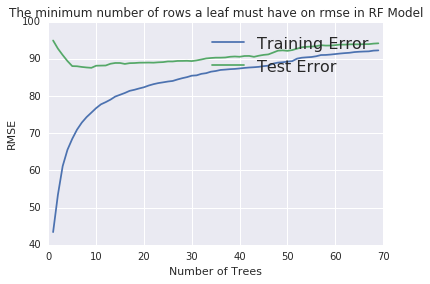

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

hyper_params = [x for x in range(1, 70)]
rmse_values = list()
rmse_values_t = list()

for hp in hyper_params:
    clf = RandomForestRegressor(n_estimators=5, random_state=1, min_samples_leaf=hp)
    clf.fit(train[features_3], train['cnt'])
   
    predictions_t = clf.predict(train[features_3])
    train_mse_t = mean_squared_error(predictions_t, train['cnt'])
    train_rmse_t = np.sqrt(train_mse_t)
    rmse_values_t.append(train_rmse_t)
    
    predictions_3 = clf.predict(test[features_3])
    test_mse_3 = mean_squared_error(predictions_3, test['cnt'])
    test_rmse_3 = np.sqrt(test_mse_3)
    rmse_values.append(test_rmse_3)

plt.plot(hyper_params, rmse_values_t, label='Training Error')
plt.plot(hyper_params, rmse_values, label='Test Error')

plt.legend()

plt.title('The minimum number of rows a leaf must have on rmse in RF Model')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.show()

In [48]:
min(rmse_values)

87.57479340119251

The random forest regressor model performed the best.

The testing error continues to decrease as we increase the number of rows a leaf